In [121]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from adjustText import adjust_text

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from adjustText import adjust_text

def simi_sampler(data, class_label, compare_with=0, plot=False, sample_size=None):
    # Identify the relevant feature columns, excluding 'class' and 'flag'
    # add flag column equal to index if not present
    if 'flag' not in data.columns:
        data['flag'] = data.index
        
    vars = data.columns[(data.columns != 'class') & (data.columns != 'flag') & (data.columns != 'Sample')]
    

    # Convert feature columns to numeric, coerce errors to NaN
    sampler_data = data[vars].apply(pd.to_numeric, errors='coerce')
    # Check for NaN and infinite values before handling
    nan_count = sampler_data.isna().sum().sum()
    inf_count = np.isinf(sampler_data.values).sum()

    sampler_data.fillna(sampler_data.mean(), inplace=True)
  

    # Remove columns with zero variance (constant columns)
    zero_var_cols = sampler_data.columns[sampler_data.nunique() <= 1]
    if len(zero_var_cols) > 0:
        print(f"Dropping zero variance columns: {zero_var_cols.tolist()}")
        sampler_data.drop(columns=zero_var_cols, inplace=True)
        vars = sampler_data.columns  # Update vars
    else:
        print("No zero variance columns to drop.")

    # Check for NaN and infinite values after handling
    nan_count_after = sampler_data.isna().sum().sum()
    inf_count_after = np.isinf(sampler_data.values).sum()
    print(f"Total NaN values after handling: {nan_count_after}")
    print(f"Total infinite values after handling: {inf_count_after}")

    # Proceed with scaling
    scaler = StandardScaler()
    sampler_data_scaled = pd.DataFrame(scaler.fit_transform(sampler_data), columns=sampler_data.columns)
    print(f"Scaled data shape: {sampler_data_scaled.shape}")

    # Get unique classes
    unique_classes = data['class'].unique()
    print(f"Unique classes: {unique_classes}")

    # Compute mean vectors and magnitudes for each class
    class_vectors = {}
    class_magnitudes = {}
    for cls in unique_classes:
        class_data = sampler_data_scaled[data['class'] == cls]
        vec = class_data.mean(axis=0).values
        mag = np.linalg.norm(vec)
        class_vectors[f'class_{cls}_vector'] = vec
        class_magnitudes[f'class_{cls}_mag'] = mag
      

    # Compute similarity of each instance with its own class
    sampler_data_scaled['0'] = np.nan
    for idx in sampler_data_scaled.index:
        row = sampler_data_scaled.loc[idx, vars].values
        current_class = data.loc[idx, 'class']
        vec = class_vectors[f'class_{current_class}_vector']
        mag = class_magnitudes[f'class_{current_class}_mag']
        row_norm = np.linalg.norm(row)
        if mag == 0 or row_norm == 0:
            similarity = 0
            print(f"Zero magnitude encountered at index {idx}, assigning similarity 0.")
        else:
            similarity = np.dot(vec, row) / (mag * row_norm)
        sampler_data_scaled.loc[idx, '0'] = similarity

    # Compute similarity between instances and all classes
    simi_df = pd.DataFrame(index=data.index)
    for cls in unique_classes:
        vec = class_vectors[f'class_{cls}_vector']
        mag = class_magnitudes[f'class_{cls}_mag']
        sim_column = []
        for idx in sampler_data_scaled.index:
            row = sampler_data_scaled.loc[idx, vars].values
            row_norm = np.linalg.norm(row)
            if mag == 0 or row_norm == 0:
                similarity = 0
            else:
                similarity = np.dot(vec, row) / (mag * row_norm)
            sim_column.append(similarity)
        simi_df[str(cls)] = sim_column
       
    # Prepare similarity table
    simi_table = pd.concat([sampler_data_scaled['0'], simi_df], axis=1)
    simi_table['class'] = data['class'].values
    simi_table['Name'] = data.iloc[:,0].values
    simi_table['flag'] = data['flag'].values
   

    # Plot similarity before truncation (if requested)
    if plot:
        x_column = str(compare_with )
        print(f"Plotting similarity for class {class_label} compared with class {compare_with }.")
        
        # Plot before truncation
        plot_data_before = simi_table.dropna(subset=[x_column, 'class'])
        plot_data_before = plot_data_before[~np.isinf(plot_data_before[x_column])]
        if not plot_data_before.empty:
            plt.figure(figsize=(10, 5))
            sns.scatterplot(
                x=plot_data_before[x_column],
                y=plot_data_before['class'],
                hue=plot_data_before['class'],
                
            )
            texts = []
            for i in range(plot_data_before.shape[0]):
                texts.append(
                    plt.text(
                        plot_data_before[x_column][i],
                        plot_data_before['class'][i],
                        plot_data_before['Name'][i],
                        fontsize=9
                    )
                )

            # Adjust text to avoid overlap
            adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

            plt.title('Similarity Before Group Truncation')
            plt.xlabel(f"Similarity with Class {compare_with }")
            plt.ylabel("Class")
            plt.legend()
            plt.show()

    # Sampling based on similarity
    simi_class = simi_table[simi_table['class'] == class_label][str(compare_with )]
    sample_size = sample_size if sample_size else len(simi_class)
    steps = np.linspace(simi_class.min(), simi_class.max(), sample_size)
    dis_mat = np.abs(np.subtract.outer(simi_class.to_numpy(), steps))

    keep_flags = []
    simi_class_indices = simi_class.index.tolist()
    if len(steps) < len(simi_class):
        for i in range(len(steps)):
            drop = np.argmin(dis_mat[:, i])
            idx = simi_class.index[drop]
            keep_flags.append(simi_table.loc[idx, 'flag'])
            dis_mat = np.delete(dis_mat, drop, axis=0)
            simi_class_indices.pop(drop)
            simi_class = simi_class.drop(idx)
            
    else:
        keep_flags = simi_table[simi_table['class'] == class_label]['flag'].tolist()

    # Plot similarity after truncation
    if plot:
        # Filter the table for the class we are plotting
        simi_table_after = simi_table[simi_table['flag'].isin(keep_flags)]
        
        # Separate the data: 
        # - Keep all data for classes other than the one we're truncating
        # - Keep only the truncated data for the specific class
        other_classes = simi_table[simi_table['class'] != class_label]  # All other classes, full data
        truncated_class = simi_table_after[simi_table_after['class'] == class_label]  # Only 'keep' samples of truncated class

        # Combine the data back together for plotting
        plot_data_after = pd.concat([other_classes, truncated_class])

        # Ensure no NaNs or infinite values in the selected columns
        plot_data_after = plot_data_after.dropna(subset=[x_column, 'class'])
        plot_data_after = plot_data_after[~np.isinf(plot_data_after[x_column])]
   
        if not plot_data_after.empty:
            plt.figure(figsize=(10, 5))
            sns.scatterplot(
                x=plot_data_after[x_column],
                y=plot_data_after['class'],
                hue=plot_data_after['class']
            )
            texts = []
            for cls in plot_data_after['class'].unique():
                class_data = plot_data_after[plot_data_after['class'] == cls]
                for i in range(class_data.shape[0]):
                    texts.append(
                        plt.text(
                            class_data[x_column].iloc[i],
                            class_data['class'].iloc[i],
                            class_data['Name'].iloc[i],
                            fontsize=9
                        )
                    )
            # Adjust text to avoid overlap
            adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
                
            plt.title('Similarity After Group Truncation')
            plt.xlabel(f"Similarity with Class {compare_with }")
            plt.ylabel("Class")
            # legend always on the right
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            
            plt.show()

    return keep_flags







In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

def stratified_sampling(df, group, size):
    """
    Performs stratified sampling on a DataFrame based on the grouping variable.

    Parameters:
    - df (pd.DataFrame): The DataFrame to sample from.
    - group (str): The name of the column to group by for stratification.
    - size (int, float, dict): Desired sample size:
                               - If int, it specifies a fixed number of samples per group.
                               - If float < 1, it specifies the proportion to sample from each group.
                               - If dict, it specifies the exact number of samples for each group.

    Returns:
    - pd.DataFrame: A stratified sample of the original DataFrame.
    """
    
    # Group by the specified column
    grouped = df.groupby(group)

    # Initialize an empty DataFrame to store the stratified sample
    stratified_sample = pd.DataFrame()

    # Iterate through each group in the DataFrame
    for name, group_data in grouped:
        group_size = len(group_data)

        # Determine the number of samples based on the type of `size`
        if isinstance(size, int):
            n_samples = min(size, group_size)  # Take all if group size is smaller than `size`
        elif isinstance(size, float) and size < 1:
            n_samples = max(1, int(size * group_size))  # Take a proportion
        elif isinstance(size, dict):
            n_samples = min(size.get(name, 0), group_size)  # Take from dict, but ensure we don’t exceed group size
        else:
            raise ValueError("size must be an integer, a float < 1, or a dictionary")

        # Sample from the group
        sampled_data = group_data.sample(n=n_samples, replace=False)
        stratified_sample = pd.concat([stratified_sample, sampled_data])

    # Reset the index of the sampled DataFrame
    stratified_sample = stratified_sample.reset_index(drop=True)
    
    return stratified_sample


def plot_distribution_scatter(data, group, x_column='index', title='Class Distribution'):
    """
    Plots the class distribution using a scatter plot, with text annotations and adjusted labels.

    Parameters:
    - data (pd.DataFrame): The DataFrame whose distribution to plot.
    - group (str): The name of the column representing classes/groups.
    - x_column (str): Column to use for x-axis (default is 'index' for basic class scatter).
    - title (str): The title of the plot.
    """
    # Ensure the index column exists for x-axis if not provided
    if x_column == 'index':
        data = data.reset_index()

    # Prepare plot
    plt.figure(figsize=(10, 5))
    
    # Scatterplot with class hue
    sns.scatterplot(
        x=data[x_column],
        y=data[group],
        hue=data[group]
    )
    
    # Add text labels to each point, adjusting for overlaps
    texts = []
    for cls in data[group].unique():
        class_data = data[data[group] == cls]
    
        for i in range(class_data.shape[0]):
            texts.append(
                plt.text(
                    class_data[x_column].iloc[i],
                    class_data[group].iloc[i],
                    class_data.iloc[:,1].iloc[i],  # Use index or add a 'Name' column if needed
                    fontsize=9
                )
            )
    
    # Adjust text positions to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
    
    # Set title, labels, and legend
    plt.title(title)
    plt.xlabel(f"{x_column}")
    plt.ylabel(f"{group}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Legend on the right side
    
    # Show the plot
    plt.show()


def stratified_sampling_with_plots(df, group, size , plot=True):
    """
    Performs stratified sampling and plots the distribution before and after sampling.

    Parameters:
    - df (pd.DataFrame): The DataFrame to sample from.
    - group (str): The name of the column to group by for stratification.
    - size (int, float, dict): Desired sample size (same as stratified_sampling function).
    
    Returns:
    - pd.DataFrame: A stratified sample of the original DataFrame.
    """
    if plot:
    # Plot distribution before sampling
        plot_distribution_scatter(df, group, title="Class Distribution Before Stratified Sampling")

    # Perform stratified sampling
    stratified_sample = stratified_sampling(df, group, size)
    
    if plot:
    # Plot distribution after sampling
        plot_distribution_scatter(stratified_sample, group, title="Class Distribution After Stratified Sampling")
    
    return stratified_sample


In [2]:
import os
os.chdir(r'C:\Users\edens\Documents\GitHub\LabCode\MolFeatures\modeling_example')

In [3]:
import pandas as pd
df=pd.read_csv('Training_Data_rdkit_stereoelectronic.csv')
df.head()


,Sample,NPA_1_P,NPA_2_P,NPA_4_P,NPA_5_P,NPA_Avg_H_onPhos,dip_x_P,dip_y_P,dip_z_P,Total_P,...,fr_amide,fr_aryl_methyl,fr_benzene,fr_bicyclic,fr_ester,fr_ether,fr_halogen,fr_methoxy,fr_pyridine,class
0,A,0.75837,-0.38224,0.08161,-0.41290,0.104640,-0.1432,7.8847,-0.0674,7.8863,...,0,2,0,0,0,0,0,0,1,1
1,AF,0.83323,-0.40922,0.02783,-0.31913,0.077040,-4.4737,6.2763,-0.0003,7.7075,...,0,1,0,0,0,0,1,0,1,1
2,B,0.83315,-0.32011,0.09768,-0.33402,0.085380,-1.5907,4.4703,0.7205,4.7992,...,0,0,1,0,0,0,0,0,1,1
3,C,0.81776,-0.11074,0.26127,-0.37265,0.076737,3.6260,4.0164,1.4923,5.6130,...,0,0,1,0,0,1,0,1,0,1
4,D,0.81453,-0.09895,0.26849,-0.36823,0.079727,11.9013,0.8460,0.6864,11.9511,...,0,0,1,0,0,1,4,0,0,1


In [6]:
x=stratified_sampling_with_plots(df, 'class', 5, plot=False)
x

,Sample,NPA_1_P,NPA_2_P,NPA_4_P,NPA_5_P,NPA_Avg_H_onPhos,dip_x_P,dip_y_P,dip_z_P,Total_P,...,fr_amide,fr_aryl_methyl,fr_benzene,fr_bicyclic,fr_ester,fr_ether,fr_halogen,fr_methoxy,fr_pyridine,class
0,F,0.83113,-0.38302,0.03636,-0.32593,0.084057,5.7464,0.4854,1.7397,6.0236,...,0,0,0,0,1,1,1,1,3,1
1,A,0.75837,-0.38224,0.08161,-0.41290,0.104640,-0.1432,7.8847,-0.0674,7.8863,...,0,2,0,0,0,0,0,0,1,1
2,E,0.86105,-0.35985,0.05288,-0.33210,0.061477,3.7887,1.2550,4.8959,6.3166,...,0,2,0,0,0,1,0,0,2,1
3,AF,0.83323,-0.40922,0.02783,-0.31913,0.077040,-4.4737,6.2763,-0.0003,7.7075,...,0,1,0,0,0,0,1,0,1,1
4,B,0.83315,-0.32011,0.09768,-0.33402,0.085380,-1.5907,4.4703,0.7205,4.7992,...,0,0,1,0,0,0,0,0,1,1
5,N,0.83788,-0.36989,0.03563,-0.11738,0.092717,6.6429,7.3962,-0.0001,9.9414,...,0,0,0,0,0,0,0,0,0,2
6,Y,0.90746,-0.32113,0.08690,-0.37238,0.016827,-11.9648,10.8784,3.8715,16.6279,...,0,1,1,3,0,0,1,0,1,2
7,V,0.85151,-0.37325,0.05186,-0.33772,0.070010,4.0445,6.1086,0.6144,7.3519,...,0,0,1,0,0,0,0,0,1,2
8,AD,0.83811,0.41920,-0.09845,-0.41791,0.069693,8.6754,-8.5162,-0.0017,12.1568,...,0,0,2,1,0,1,3,0,1,2
9,X,0.84966,-0.37202,0.07320,-0.33669,0.070620,-15.5282,7.0924,-6.1823,18.1562,...,0,0,1,0,0,0,4,0,2,2


No zero variance columns to drop.
Total NaN values after handling: 0
Total infinite values after handling: 0
Scaled data shape: (46, 64)
Unique classes: [1 2 3]
Plotting similarity for class 2 compared with class 1.


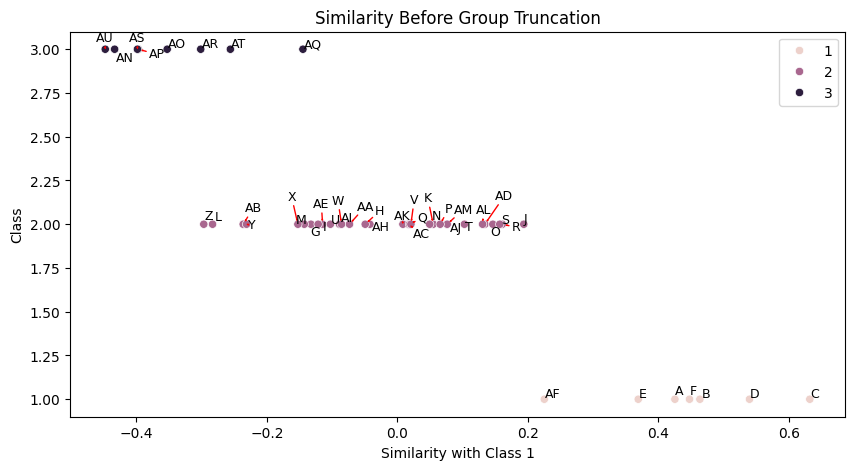

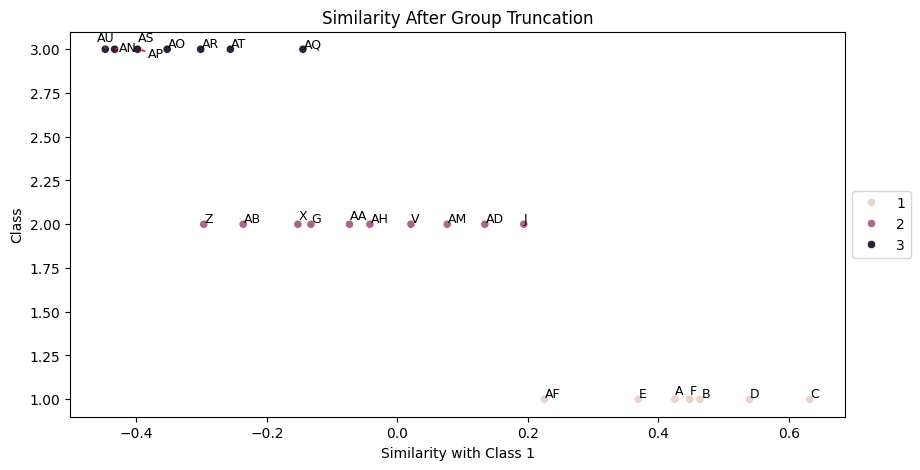

[37, 8, 35, 18, 7, 12, 33, 17, 10, 21]

In [124]:
simi_sampler(df, 2, compare_with=1, plot=True, sample_size=10)

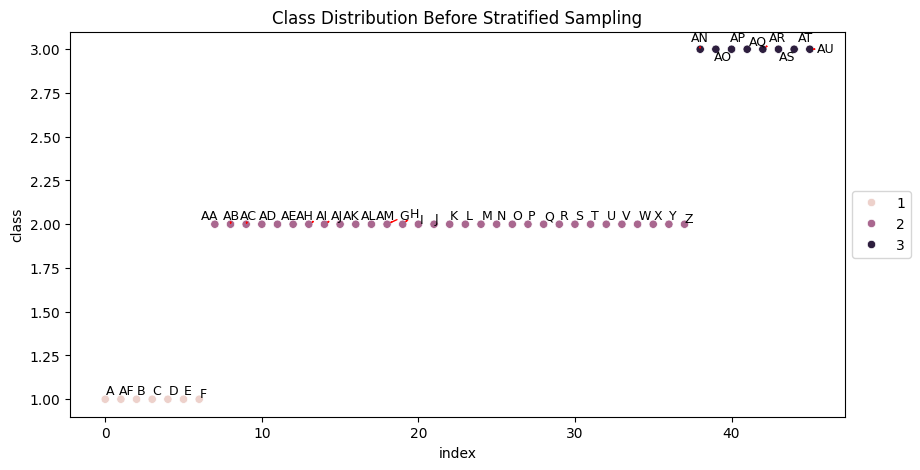

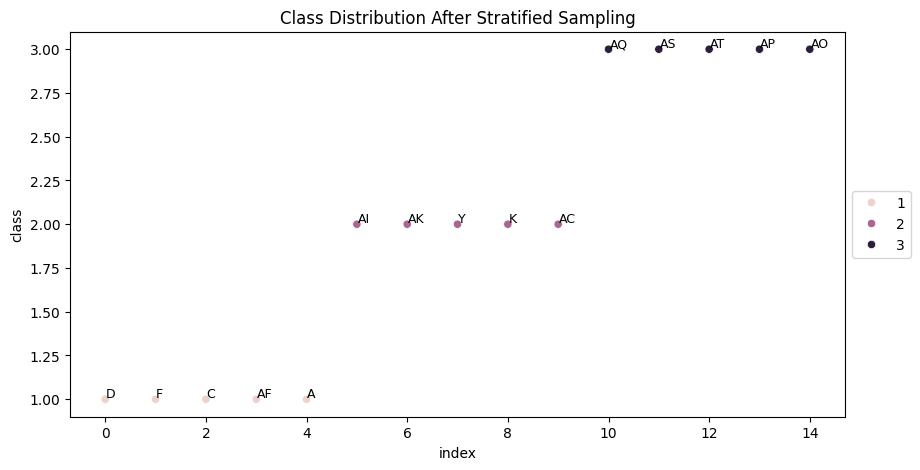

,Sample,NPA_1_P,NPA_2_P,NPA_4_P,NPA_5_P,NPA_Avg_H_onPhos,dip_x_P,dip_y_P,dip_z_P,Total_P,...,fr_aryl_methyl,fr_benzene,fr_bicyclic,fr_ester,fr_ether,fr_halogen,fr_methoxy,fr_pyridine,class,flag
0,D,0.81453,-0.09895,0.26849,-0.36823,0.079727,11.9013,0.8460,0.6864,11.9511,...,0,1,0,0,1,4,0,0,1,4
1,F,0.83113,-0.38302,0.03636,-0.32593,0.084057,5.7464,0.4854,1.7397,6.0236,...,0,0,0,1,1,1,1,3,1,6
2,C,0.81776,-0.11074,0.26127,-0.37265,0.076737,3.6260,4.0164,1.4923,5.6130,...,0,1,0,0,1,0,1,0,1,3
3,AF,0.83323,-0.40922,0.02783,-0.31913,0.077040,-4.4737,6.2763,-0.0003,7.7075,...,1,0,0,0,0,1,0,1,1,1
4,A,0.75837,-0.38224,0.08161,-0.41290,0.104640,-0.1432,7.8847,-0.0674,7.8863,...,2,0,0,0,0,0,0,1,1,0
5,AI,0.86596,-0.43481,0.03001,-0.33047,0.069823,3.4790,7.2660,-1.2465,8.1518,...,0,0,0,0,1,0,0,2,2,13
6,AK,0.85080,-0.38566,0.05587,-0.34281,0.070140,1.7418,8.4681,-0.1568,8.6468,...,1,0,1,0,0,0,0,1,2,15
7,Y,0.90746,-0.32113,0.08690,-0.37238,0.016827,-11.9648,10.8784,3.8715,16.6279,...,1,1,3,0,0,1,0,1,2,36
8,K,0.85289,-0.34214,0.09586,-0.36341,0.077873,-3.1375,7.6843,1.9370,8.5231,...,1,0,0,0,0,3,0,1,2,22
9,AC,0.85913,-0.36713,0.05092,-0.33983,0.071183,6.8548,4.7053,-0.0042,8.3143,...,0,1,0,0,0,0,0,1,2,9


In [144]:
stratified_sampling_with_plots(df, 'class', 5)

In [145]:
from statsmodels.miscmodels.ordinal_model import OrderedModel